 # Imports Setup

In [14]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline

In [2]:
from datetime import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
# import modin.pandas as pd
# import modin
import pandas as pd
from scipy.optimize import minimize 
from utils import *
from importlib import reload
from collections import defaultdict

import matplotlib.font_manager as fm

In [3]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Raleway'
plt.rcParams['font.style'] = "normal"
# plt.rcParams['font.weight'] = 'Light'
# plt.rcParams['font.serif'] = 'Times New Roman'
# plt.rcParams['font.size'] = 12
# font.cursive
# font.family
# font.fantasy
# font.monospace
# font.sans-serif
# font.serif
# font.size
# font.stretch
# font.style
# font.variant
# font.weight
# legend.fontsize
# legend.title_fontsize
# mathtext.fontset
# pdf.fonttype
# pdf.use14corefonts
# pgf.rcfonts
# ps.fonttype
# svg.fonttype

# plot_trading_rule(dfXcpi, dfrtn, xcol=xcol, rtn_col=rtn_col, 
#                   weights=weights, save_plot=True, show_plot=True)

# for k in plt.rcParams.keys():
#     if "font" in k:
#         print(k)

In [4]:
import strategies
from strategies import calc_excess_returns, factor_barplot, portfolio_performance, negative_sharpe_ratio, optimize_portfolio, calculate_factor_exposures, calculate_factor_exposures2, calc_strat_returns

In [5]:
dfcpi_fred = pd.read_parquet("workspace/cpi_fred_factors.pq").reset_index()

In [6]:
df_all = pd.read_parquet("workspace/dfreturns_with_factors.pq")


factor_cols = ['date', 'refmonthyear', 'cpi.hml', 'pmi.hml', 'nmi.hml', 
                '3M_rising', '6M_rising', '9M_rising', '12M_rising']

cpi_factors = ['date', 'refmonthyear', 
               '3M_rising', '6M_rising', '9M_rising', '12M_rising',
               '3M_rising_yoy', '6M_rising_yoy', '9M_rising_yoy', '12M_rising_yoy']

rtn_cols = [c for c in df_all.columns if c.startswith('rtn') & c.endswith("M")]
tickers = list(df_all['ticker'].unique())

# Need to unstack returns per sector to split factor columns
dfrtn = df_all.pivot(columns="ticker", index=['date', 'refmonthyear'], values=rtn_cols)
head(dfrtn)

dfX = df_all[factor_cols].copy().drop_duplicates()
dfX.set_index(['date', 'refmonthyear'], inplace=True)



dfXcpi = dfcpi_fred[cpi_factors].copy().drop_duplicates()
dfXcpi.set_index(['date', 'refmonthyear'], inplace=True)

fwd_returns = {}

df2 = dfrtn.stack(future_stack=True)
df2.reset_index(inplace=True)

for ticker in tickers:
    fwd_returns[ticker] = df2[df2['ticker'] == ticker].copy()

del df2

In [7]:
def get_weight(ticker, sigval, weights):
    if sigval is None:
        return 0
    return weights[sigval][ticker]
    
def zero():
    return 0

In [8]:
def apply_trading_rule(dfX, dfrtn, xcol, rtn_col, weights):
    tickers = dfrtn[rtn_col].columns.values
    
    # strat_code = f"totrtn.{xcol}.{rtn_col}"
    
    dfjoint = pd.merge(dfrtn[rtn_col].reset_index(), 
                       dfX[xcol].reset_index(), 
                       left_on='refmonthyear', 
                       right_on='refmonthyear', 
                       suffixes=('', '_y'),
                       how='inner').dropna()
    dfjoint = dfjoint[dfjoint[xcol] != None]    
    
    for ticker in tickers:
        wgtcol = f"wgt.{ticker}" 
        wgtrtncol = f"wgtrtn.{ticker}" 
        dfjoint[wgtcol] = dfjoint[xcol].apply(lambda x: get_weight(ticker, x, weights))
        dfjoint[wgtrtncol] = dfjoint[wgtcol] * dfjoint[ticker]
    
    wgtreturns = dfjoint[[c for c in dfjoint.columns if c.startswith('wgtrtn')]].copy()
    # wgtreturns[strat_code] = np.cumprod(wgtreturns.agg(func='sum', axis='columns').apply(lambda x: 1+x)) * 100
    wgtreturns['totrtn'] = np.cumprod(wgtreturns.agg(func='sum', axis='columns').apply(lambda x: 1+x)) * 100
    wgtreturns = pd.DataFrame(wgtreturns['totrtn']).reset_index()
    wgtreturns['date'] = dfjoint['date'].copy()
    wgtreturns['refmonthyear'] = dfjoint['refmonthyear'].copy()
    wgtreturns = wgtreturns.sort_values('date')
    # wgtreturns.set_index('date', inplace=True)
    return wgtreturns


def plot_trading_rule(dfX, dfrtn, xcol, rtn_col, weights, 
                      save_plot=True, show_plot=False, title=None,
                     xlabel=None, ylabel=None):
    if title is None:
        title = f"totrtn.{xcol}.{rtn_col}"
    strat_return = apply_trading_rule(dfX, dfrtn, xcol, rtn_col, weights=weights)
    
    mktweights = defaultdict(zero)
    spxlong = defaultdict(zero)
    spxlong['spx'] = 1
    mktweights[True] = spxlong
    mktweights[False] = spxlong
    mkt_return = apply_trading_rule(dfX, dfrtn, xcol, rtn_col, weights=mktweights)
    if not show_plot:
        plt.ioff()


    plt.figure(figsize=(10, 4))
    
    plt.plot(strat_return['date'], strat_return['totrtn'], label='Long/Short');
    plt.plot(mkt_return['date'], mkt_return['totrtn'], label='SPX');
    plt.title(title);
    plt.legend();
    plt.grid(ls='--', alpha=.5);

    if xlabel is not None:
        plt.xlabel(xlabel)

    if ylabel is not None:
        plt.ylabel(ylabel)

    
    if save_plot:
        figname = f"img/trading_rule_plots/{title}.png"
        plt.savefig(figname, dpi=200)

    if show_plot:
        plt.show()

    plt.close()
    plt.ion()

# Strategy 1: Long/Short top 2 tickers 
Rising 3Mth inflation ~ 6Mth Return:  
    Long Tech  ```s5tech```  
    Long Energy  ```s5enrs```  
    Short Cons Staples  ```s5cons```  
    Short Healthcare  ```s5hlth```  

Falling 3Mth inflation ~ 6Mth Return:  
    Long Tech  ```s5tech```  
    Long Materials  ```s5matr```  
    Short Cons Staples  ```s5cons```  
    Short Financials  ```s5finl```  

In [89]:
rising_weights = defaultdict(zero)
falling_weights = defaultdict(zero)
weights = defaultdict(zero)

rising_weights['s5tech'] = 1
rising_weights['s5enrs'] = 1
rising_weights['s5cond'] = -1
rising_weights['s5hlth'] = -1

falling_weights['s5tech'] = 1
falling_weights['s5matr'] = 1
falling_weights['s5cons'] = -1
falling_weights['s5finl'] = -1


weights[True] = rising_weights
weights[False] = falling_weights

xcol = '3M_rising_yoy'
rtn_col = 'rtn_6M'
title = "6M Fwd Returns ~ 3M Rising CPI YoY"
xlabel = 'Date'
ylabel = 'Total Return'
# rtn_cols=[f"rtn_{i+1}M" for i in range(12)]
strat_rtn = apply_trading_rule(dfXcpi, dfrtn, xcol, rtn_col, weights)
plot_trading_rule(dfXcpi, dfrtn, xcol=xcol, 
                  rtn_col=rtn_col, weights=weights, 
                  save_plot=True, show_plot=True,
                 title=title, xlabel=xlabel, ylabel=ylabel)

In [313]:
pd.merge(dfrtn[rtn_col].reset_index(), 
         dfXcpi[xcol].reset_index(), 
         left_on='refmonthyear', 
         right_on='refmonthyear', 
         suffixes=('', '_y'),
         how='inner')

# Strategy 2: Long/Short top 2 tickers 
Rising 3Mth inflation ~ 3Mth Return:  
    Long Tech  ```s5tech```  
    Long Fins  ```s5finl```  
    Short Energy  ```s5enrs```  
    Short Industrials  ```s5indu```  

Falling 3Mth inflation ~ 3Mth Return:  
    Long Energy  ```s5enrs```  
    Long Tech  ```s5tech```  
    Short Fins  ```s5finl```  
    Short Cons Staples  ```s5cons```  

In [46]:
rising_weights = defaultdict(zero)
falling_weights = defaultdict(zero)
weights = defaultdict(zero)

rising_weights['s5tech'] = 1
rising_weights['s5finl'] = 1
rising_weights['s5enrs'] = -1
rising_weights['s5indu'] = -1

falling_weights['s5enrs'] = 1
falling_weights['s5tech'] = 1
falling_weights['s5finl'] = -1
falling_weights['s5cons'] = -1


weights[True] = rising_weights
weights[False] = falling_weights

title = "3M Fwd Returns ~ 3M Rising CPI YoY"
xlabel = 'Date'
ylabel = 'Total Return'

xcol = '3M_rising'
rtn_col = 'rtn_3M'
# rtn_cols=[f"rtn_{i+1}M" for i in range(12)]
plot_trading_rule(dfX, dfrtn, xcol=xcol, rtn_col=rtn_col, weights=weights, save_plot=True, 
                  show_plot=True, title=title, xlabel=xlabel, ylabel=ylabel)

# $\Delta cpi.yoy\$ ~ Mean Return x sector

In [10]:
dfX = pd.merge(left=dfX.reset_index(), right=dfXcpi.reset_index(), left_on='refmonthyear', right_on='refmonthyear', suffixes=(None, '_y'))
dfX.drop(columns=[x for x in dfX.columns if x.endswith("_y")], axis=1, inplace=True)

dfX.set_index(['date', 'refmonthyear'], inplace=True)

In [11]:
dfrtn2 = dfrtn.stack(future_stack=True).reset_index()
head(dfrtn2)

,date,refmonthyear,ticker,rtn_1M,rtn_2M,rtn_3M,rtn_4M,rtn_5M,rtn_6M,rtn_7M,rtn_8M,rtn_9M,rtn_10M,rtn_11M,rtn_12M
0,1989-10-31,OCT.1989,s5cond,0.002487,-0.005630,-0.008771,-0.024954,-0.018526,-0.007617,-0.012665,-0.005347,-0.001097,-0.008358,-0.004850,-0.011541
1,1989-10-31,OCT.1989,s5cons,0.003381,-0.005241,-0.008791,-0.024514,-0.019104,-0.004227,-0.011665,-0.004057,0.001014,-0.007946,0.004227,0.010651
2,1989-10-31,OCT.1989,s5enrs,-0.000362,-0.006633,-0.006874,-0.020381,-0.015437,-0.012301,-0.023758,-0.017004,-0.013025,-0.010613,-0.003377,-0.004221
3,1989-10-31,OCT.1989,s5finl,0.003913,-0.002398,-0.004039,-0.021457,-0.014893,0.001767,0.000252,0.001388,0.000252,-0.007194,-0.000884,0.005049
4,1989-10-31,OCT.1989,s5hlth,0.008721,0.004506,0.000436,-0.015116,-0.005523,0.011773,0.014680,0.030669,0.016424,0.006977,0.019186,0.018023


In [12]:
rtn_col = 'rtn_1M'
xcol = '3M_rising_yoy'
dfrtn_cpi2 = pd.merge(dfrtn2, 
         dfXcpi.reset_index(), 
         left_on='refmonthyear', 
         right_on='refmonthyear', 
         suffixes=('', '_y'),
         how='inner').drop('date_y', axis='columns')

In [13]:
cpi_factors = ['3M_rising_yoy', '6M_rising_yoy', '9M_rising_yoy', '12M_rising_yoy']
rtn_cols = [f"rtn_{i+1}M" for i in range(12)]

# for rtncol in rtn_cols:
#     for xcol in cpi_factors:
#         dfrtn_cpi2[xcol] = pd.Categorical(dfrtn_cpi2[xcol], categories=[True, False], ordered=True)
#         strategies.factor_barplot(dfrtn_cpi2, factor_col = xcol, rtn_col = rtncol, save_plot=True, 
#                                   use_excess_returns=False, show_plot=False)

In [14]:
dfrtn_cpi2[dfrtn_cpi2.ticker == 'spx'].to_clipboard()

Changes since last call - updated signal to work on relative changes in YoY CPI instead of absolute -- now roughly 50/50 split between rising & falling regimes across CPI signal horizons. 

# Strategy 3: Long/Short top 2 tickers with CPI Signal v2
Rising 3Mth inflation ~ 3Mth Return:  
    Long Tech  ```s5tech```  
    Long Healthcare  ```s5hlth```  
    Short Energy  ```s5enrs```  
    Short Industrials  ```s5indu```  

Falling 3Mth inflation ~ 3Mth Return:  
    Long Tech  ```s5tech```  
    Long Fins  ```s5finl```  
    Short Healthcare  ```s5hlth```  
    Short Cons Staples  ```s5cons```  

In [79]:
xcol = '3M_rising_yoy'
rtn_col = 'rtn_3M'
title = "3M Fwd Returns ~ 3M Rising CPI YoY"
ylabel = "Excess 3M Fwd Return"
xlabel = "Sector Ticker"
factor_barplot(dfrtn_cpi2, xcol, rtn_col, show_plot=True, save_plot=False, 
               figsize=(10,4), ylabel=ylabel, xlabel=xlabel)

In [429]:
rising_weights = defaultdict(zero)
falling_weights = defaultdict(zero)
weights = defaultdict(zero)

rising_weights['s5tech'] = 1
rising_weights['s5hlth'] = 1
rising_weights['s5enrs'] = -1
rising_weights['s5indu'] = -1

falling_weights['s5tech'] = 1
falling_weights['s5finl'] = 1
falling_weights['s5hlth'] = -1
falling_weights['s5cons'] = -1


weights[True] = rising_weights
weights[False] = falling_weights

xcol = '3M_rising_yoy'
rtn_col = 'rtn_3M'
# rtn_cols=[f"rtn_{i+1}M" for i in range(12)]
# X = 
plot_trading_rule(dfX, dfrtn, xcol=xcol, rtn_col=rtn_col, weights=weights, save_plot=True, show_plot=True)

# Strategy 4: Long/Short top 2 tickers with CPI Signal v2, 3M Rtn ~ 6M CPI Rising
Rising 3Mth Return ~ 6Mth Inflation:  
    Long Tech  ```s5tech```  
    Long Healthcare  ```s5hlth```  
    Short Cons Disc  ```s5cond```  
    Short Industrials  ```s5indu```  

Falling 3Mth Return ~ 6Mth Inflation:  
    Long Tech  ```s5tech```  
    Long Cons Disc  ```s5cond```  
    Short Healthcare  ```s5hlth```  
    Short Cons Staples  ```s5cons```  

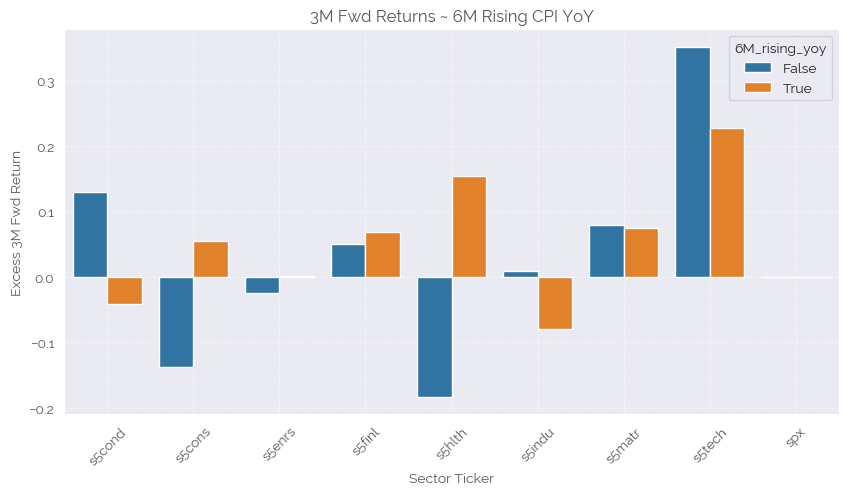

In [92]:
rising_weights = defaultdict(zero)
falling_weights = defaultdict(zero)
weights = defaultdict(zero)

rising_weights['s5tech'] = 1
rising_weights['s5hlth'] = 1
rising_weights['s5cond'] = -1
rising_weights['s5indu'] = -1

falling_weights['s5tech'] = 1
falling_weights['s5cond'] = 1
falling_weights['s5hlth'] = -1
falling_weights['s5cons'] = -1


weights[True] = rising_weights
weights[False] = falling_weights

title = "3M Fwd Returns ~ 6M Rising CPI YoY"
xlabel = 'Date'
ylabel = 'Total Return'

plot_trading_rule(dfX, dfrtn, xcol=xcol, rtn_col=rtn_col, weights=weights, save_plot=True, show_plot=True, 
                  title=title, xlabel=xlabel, ylabel=ylabel)

# Strategy 5: Long/Short top 2 tickers with CPI Signal v2, 6M Rtn ~ 6M CPI Rising
Rising 6Mth Return ~ 6Mth Inflation:  
    Long Tech  ```s5tech```  
    Long Energy  ```s5enrs```  
    Short Fins  ```s5finl```  
    Short Cons Disc  ```s5cond```  

Falling 6Mth Return ~ 6Mth Inflation:  
    Long Tech  ```s5tech```  
    Long Fins  ```s5finl```  
    Short Healthcare  ```s5hlth```  
    Short Cons Staples  ```s5cons```  

In [9]:
xcol = '6M_rising_yoy'
rtn_col = 'rtn_6M'
title = "6M Fwd Returns ~ 6M Rising CPI YoY"
ylabel = "Excess 6M Fwd Return"
xlabel = "Sector Ticker"

plt.rcParams['figure.figsize'] = (6,3)
factor_barplot(dfrtn_cpi2, xcol, rtn_col, show_plot=True, save_plot=False, 
               figsize=(6,3), ylabel=ylabel, xlabel=xlabel)

# factor_barplot(dfrtn_cpi2, xcol, rtn_col, show_plot=True, save_plot=True)

NameError: name 'dfrtn_cpi2' is not defined

In [433]:
rising_weights = defaultdict(zero)
falling_weights = defaultdict(zero)
weights = defaultdict(zero)

rising_weights['s5tech'] = 1
rising_weights['s5enrs'] = 1
rising_weights['s5finl'] = -1
rising_weights['s5cond'] = -1

falling_weights['s5tech'] = 1
falling_weights['s5finl'] = 1
falling_weights['s5hlth'] = -1
falling_weights['s5cons'] = -1


weights[True] = rising_weights
weights[False] = falling_weights


plot_trading_rule(dfX, dfrtn, xcol=xcol, rtn_col=rtn_col, weights=weights, save_plot=True, show_plot=True)

# Factor barplots pre 2013

In [94]:
from datetime import date

In [100]:
mask = dfrtn_cpi2['date'] < pd.to_datetime(date(2013, 1, 1))

In [101]:
mask2 = dfrtn_cpi2['date'] >= pd.to_datetime(date(2013, 1, 1))

In [116]:
xcol = '3M_rising_yoy'
rtn_col = 'rtn_1M'
# rtn_cols=[f"rtn_{i+1}M" for i in range(12)]
# X = 
title = "{} Fwd Returns ~ 3M Rising CPI YoY".format(rtn_col.replace("rtn_", ""))
ylabel = "Excess 3M Fwd Return"
xlabel = "Sector Ticker"


factor_barplot(dfrtn_cpi2[mask], xcol, rtn_col, show_plot=True, save_plot=False, 
               figsize=(10,4), ylabel=ylabel, xlabel=xlabel, 
               title=f"{title} - pre 2013")
# factor_barplot(dfrtn_cpi2, xcol, rtn_col, show_plot=True, save_plot=False)

In [117]:
factor_barplot(dfrtn_cpi2[mask2], xcol, rtn_col, show_plot=True, save_plot=False, 
               figsize=(10,4), ylabel=ylabel, xlabel=xlabel, 
               title=f"{title} - post 2013")

In [118]:
factor_barplot(dfrtn_cpi2, xcol, rtn_col, show_plot=True, save_plot=False, 
               figsize=(10,4), ylabel=ylabel, xlabel=xlabel, 
               title=f"{title} - 1989 -- 2023")

In [109]:
xcol = '3M_rising_yoy'
rtn_col = 'rtn_2M'
# rtn_cols=[f"rtn_{i+1}M" for i in range(12)]
# X = 
title = "{} Fwd Returns ~ 3M Rising CPI YoY".format(rtn_col.replace("rtn_", ""))
ylabel = "Excess 3M Fwd Return"
xlabel = "Sector Ticker"
factor_barplot(dfrtn_cpi2[mask], xcol, rtn_col, show_plot=True, save_plot=False, 
               figsize=(10,4), ylabel=ylabel, xlabel=xlabel, 
               title=f"{title} - pre 2013")
# factor_barplot(dfrtn_cpi2, xcol, rtn_col, show_plot=True, save_plot=False)

factor_barplot(dfrtn_cpi2[mask2], xcol, rtn_col, show_plot=True, save_plot=False, 
               figsize=(10,4), ylabel=ylabel, xlabel=xlabel, 
               title=f"{title} - post 2013")

In [110]:
xcol = '3M_rising_yoy'
rtn_col = 'rtn_3M'
# rtn_cols=[f"rtn_{i+1}M" for i in range(12)]
# X = 
title = "{} Fwd Returns ~ 3M Rising CPI YoY".format(rtn_col.replace("rtn_", ""))
ylabel = "Excess 3M Fwd Return"
xlabel = "Sector Ticker"
factor_barplot(dfrtn_cpi2[mask], xcol, rtn_col, show_plot=True, save_plot=False, 
               figsize=(10,4), ylabel=ylabel, xlabel=xlabel, 
               title=f"{title} - pre 2013")
# factor_barplot(dfrtn_cpi2, xcol, rtn_col, show_plot=True, save_plot=False)

factor_barplot(dfrtn_cpi2[mask2], xcol, rtn_col, show_plot=True, save_plot=False, 
               figsize=(10,4), ylabel=ylabel, xlabel=xlabel, 
               title=f"{title} - post 2013")

# 6M Rising YoY

In [111]:
xcol = '6M_rising_yoy'
rtn_col = 'rtn_1M'
# rtn_cols=[f"rtn_{i+1}M" for i in range(12)]
# X = 
title = "{} Fwd Returns ~ {} Rising CPI YoY".format(rtn_col.replace("rtn_", ""), xcol.replace("_rising_yoy", ""))
ylabel = "Excess {} Fwd Return".format(rtn_col.replace("rtn_", ""))
xlabel = "Sector Ticker"
factor_barplot(dfrtn_cpi2[mask], xcol, rtn_col, show_plot=True, save_plot=False, 
               figsize=(10,4), ylabel=ylabel, xlabel=xlabel, 
               title=f"{title} - pre 2013")
# factor_barplot(dfrtn_cpi2, xcol, rtn_col, show_plot=True, save_plot=False)

factor_barplot(dfrtn_cpi2[mask2], xcol, rtn_col, show_plot=True, save_plot=False, 
               figsize=(10,4), ylabel=ylabel, xlabel=xlabel, 
               title=f"{title} - post 2013")

In [112]:
xcol = '6M_rising_yoy'
rtn_col = 'rtn_2M'
# rtn_cols=[f"rtn_{i+1}M" for i in range(12)]
# X = 
title = "{} Fwd Returns ~ {} Rising CPI YoY".format(rtn_col.replace("rtn_", ""), xcol.replace("_rising_yoy", ""))
ylabel = "Excess {} Fwd Return".format(rtn_col.replace("rtn_", ""))
xlabel = "Sector Ticker"
factor_barplot(dfrtn_cpi2[mask], xcol, rtn_col, show_plot=True, save_plot=False, 
               figsize=(10,4), ylabel=ylabel, xlabel=xlabel, 
               title=f"{title} - pre 2013")
# factor_barplot(dfrtn_cpi2, xcol, rtn_col, show_plot=True, save_plot=False)

factor_barplot(dfrtn_cpi2[mask2], xcol, rtn_col, show_plot=True, save_plot=False, 
               figsize=(10,4), ylabel=ylabel, xlabel=xlabel, 
               title=f"{title} - post 2013")

In [113]:
xcol = '6M_rising_yoy'
rtn_col = 'rtn_3M'
# rtn_cols=[f"rtn_{i+1}M" for i in range(12)]
# X = 
title = "{} Fwd Returns ~ {} Rising CPI YoY".format(rtn_col.replace("rtn_", ""), xcol.replace("_rising_yoy", ""))
ylabel = "Excess {} Fwd Return".format(rtn_col.replace("rtn_", ""))
xlabel = "Sector Ticker"
factor_barplot(dfrtn_cpi2[mask], xcol, rtn_col, show_plot=True, save_plot=False, 
               figsize=(10,4), ylabel=ylabel, xlabel=xlabel, 
               title=f"{title} - pre 2013")
# factor_barplot(dfrtn_cpi2, xcol, rtn_col, show_plot=True, save_plot=False)

factor_barplot(dfrtn_cpi2[mask2], xcol, rtn_col, show_plot=True, save_plot=False, 
               figsize=(10,4), ylabel=ylabel, xlabel=xlabel, 
               title=f"{title} - post 2013")

In [114]:
xcol = '6M_rising_yoy'
rtn_col = 'rtn_6M'
# rtn_cols=[f"rtn_{i+1}M" for i in range(12)]
# X = 
title = "{} Fwd Returns ~ {} Rising CPI YoY".format(rtn_col.replace("rtn_", ""), xcol.replace("_rising_yoy", ""))
ylabel = "Excess {} Fwd Return".format(rtn_col.replace("rtn_", ""))
xlabel = "Sector Ticker"
factor_barplot(dfrtn_cpi2[mask], xcol, rtn_col, show_plot=True, save_plot=False, 
               figsize=(10,4), ylabel=ylabel, xlabel=xlabel, 
               title=f"{title} - pre 2013")
# factor_barplot(dfrtn_cpi2, xcol, rtn_col, show_plot=True, save_plot=False)

factor_barplot(dfrtn_cpi2[mask2], xcol, rtn_col, show_plot=True, save_plot=False, 
               figsize=(10,4), ylabel=ylabel, xlabel=xlabel, 
               title=f"{title} - post 2013")

In [120]:
dates = dfrtn_cpi2['date'].unique()

In [125]:
years = list(set([d.year for d in dates]))

# Factor barplots

In [116]:
sector_map = {
    's5tech': 'Tech',
    's5hlth': 'Healthcare',
    's5enrs': 'Energy',
    's5indu': 'Industrials',
    's5finl': 'Financials',
    's5cond': 'Cons Disc',
    's5cons': 'Cons Staples',
    's5matr': 'Materials'
}

cpi_rising_map = {
    True: 'CPI Rising',
    False: 'CPI Falling'
}

In [117]:
xcol = '6M_rising_yoy'
rtn_col = 'rtn_1M'
# rtn_cols=[f"rtn_{i+1}M" for i in range(12)]
# X = 
title = "1M Fwd Returns ~ 6M Rising CPI YoY"
ylabel = "Excess 1M Fwd Return"
xlabel = "Sector Ticker"

df = dfrtn_cpi2
show_plot=True
save_plot=False
factor_col = xcol
use_excess_returns=True
# factor_barplot(dfrtn_cpi2, xcol, rtn_col, show_plot=True, save_plot=False, 
#                figsize=figsize, ylabel=ylabel, xlabel=xlabel, title=title)
# factor_barplot(dfrtn_cpi2, xcol, rtn_col, show_plot=True, save_plot=False)

/var/folders/m5/44m8lss55vg788hh111xqvsc0000gn/T/ipykernel_19474/2590910739.py:59: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  returns.replace({factor_col: cpi_rising_map}, inplace=True)


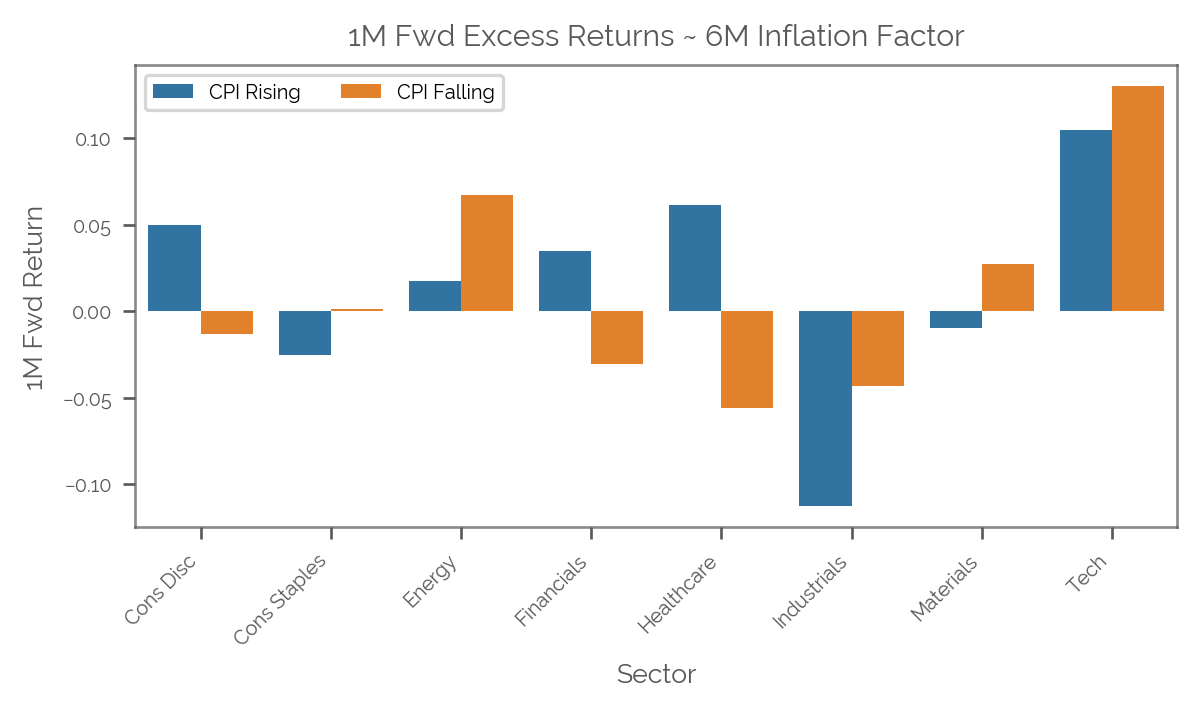

In [118]:
# sb.set_theme(style="white")
sb.reset_orig()
width_px = 410
height_px = 171
dpi = 240

width_in = 5.6
height_in = 2.5

import matplotlib.font_manager as fm
fm.fontManager.addfont("/Users/lcota/Library/Fonts/Raleway-Regular.ttf")
fm.fontManager.addfont("/Users/lcota/Library/Fonts/Raleway-Light.ttf")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Raleway'
plt.rcParams['font.style'] = "normal"

plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.titlecolor'] = '#595959'
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.labelcolor'] = '#595959'
plt.rcParams['xtick.color'] = '#595959'
plt.rcParams['ytick.color'] = '#595959'


figsize = (width_in, height_in)

# fig, ax = plt.subplots(figsize=(10,5)) 
plt.ioff()

# plt.figure(figsize=(10,5))
# sb.barplot()

# if figsize is not None:
#     plt.rcParams['figure.figsize'] = figsize



mean_returns = df[df[factor_col].isna() == False].groupby(['ticker', factor_col], observed=True)[rtn_col].agg('mean')
excess_returns = mean_returns - mean_returns['spx']
excess_returns = excess_returns.reset_index()
excess_returns = excess_returns[excess_returns['ticker'] != 'spx']

returns = mean_returns
if use_excess_returns:
    returns = excess_returns
    if title is None:
        title = f"Excess Sector Returns {rtn_col} x {factor_col}"
else:
    returns = mean_returns.reset_index()
    if title is None:
        title = f"Sector Returns {rtn_col} x {factor_col}"

returns = pd.DataFrame(returns)
returns[rtn_col] = returns[rtn_col] * 100 #convert to pct scale
returns[factor_col] = pd.Categorical(returns[factor_col], 
                                     categories=[True, False], ordered=True)

returns.replace({'ticker': sector_map}, inplace=True)
returns.replace({factor_col: cpi_rising_map}, inplace=True)

plt.figure(figsize=figsize, dpi=dpi);
sb.barplot(returns, x='ticker', y=rtn_col, hue=factor_col, legend=True);
ax = plt.gca()
ax.legend(loc="upper left", ncol=2, fontsize=6);
plt.xticks(rotation=45, ha='right', fontsize=6);
plt.yticks(fontsize=6);
plt.ylabel("1M Fwd Return", fontsize=8);
plt.xlabel("Sector", fontsize=8);

plt.title("1M Fwd Excess Returns ~ 6M Inflation Factor", fontsize=9, color='#595959')

for spine in ax.spines.values():
    spine.set_color('#595959')
    spine.set_alpha(.7)
plt.show()

## Factor barchart pre 2013

In [127]:
df['date'].dtypes

dtype('<M8[ns]')

/var/folders/m5/44m8lss55vg788hh111xqvsc0000gn/T/ipykernel_19474/175111691.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mean_returns = df[mask][df[factor_col].isna() == False].groupby(['ticker', factor_col], observed=True)[rtn_col].agg('mean')
/var/folders/m5/44m8lss55vg788hh111xqvsc0000gn/T/ipykernel_19474/175111691.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  returns.replace({factor_col: cpi_rising_map}, inplace=True)


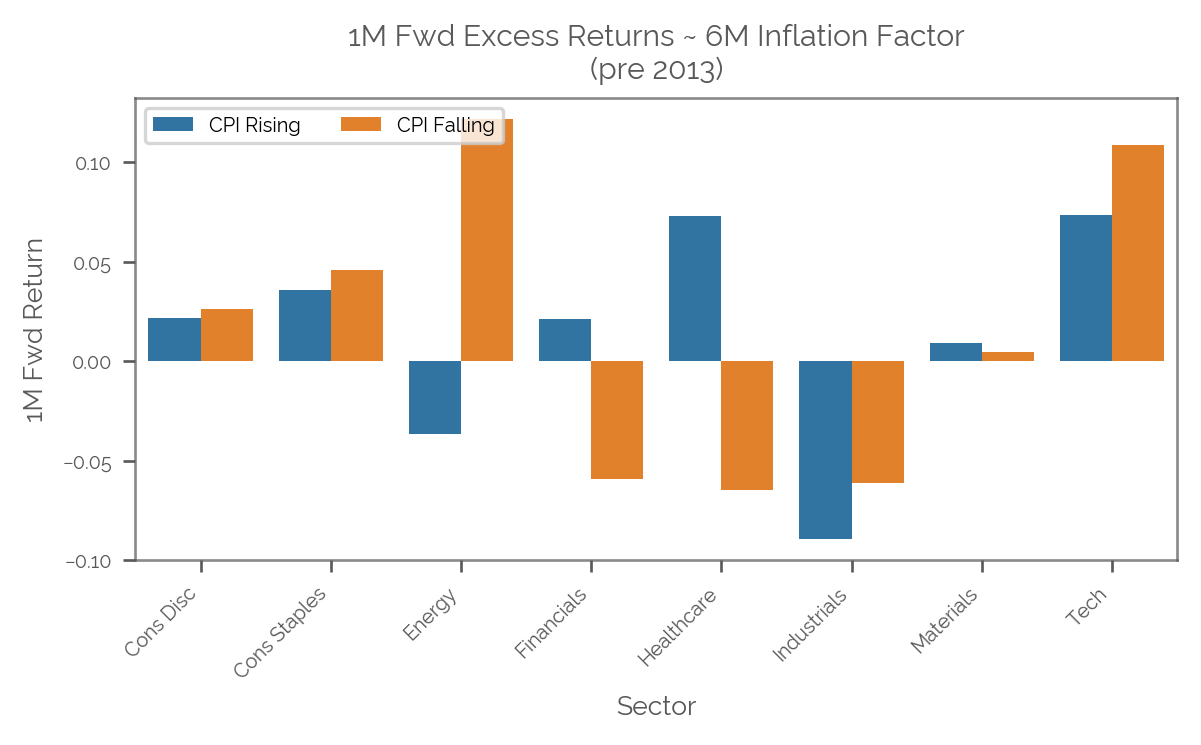

In [132]:
mask = df['date'] < pd.Timestamp(year=2013, month=1, day=1)

mean_returns = df[mask][df[factor_col].isna() == False].groupby(['ticker', factor_col], observed=True)[rtn_col].agg('mean')
excess_returns = mean_returns - mean_returns['spx']
excess_returns = excess_returns.reset_index()
excess_returns = excess_returns[excess_returns['ticker'] != 'spx']

returns = mean_returns
if use_excess_returns:
    returns = excess_returns
    if title is None:
        title = f"Excess Sector Returns {rtn_col} x {factor_col}"
else:
    returns = mean_returns.reset_index()
    if title is None:
        title = f"Sector Returns {rtn_col} x {factor_col}"

returns = pd.DataFrame(returns)
returns[rtn_col] = returns[rtn_col] * 100 #convert to pct scale
returns[factor_col] = pd.Categorical(returns[factor_col], 
                                     categories=[True, False], ordered=True)

returns.replace({'ticker': sector_map}, inplace=True)
returns.replace({factor_col: cpi_rising_map}, inplace=True)

plt.figure(figsize=figsize, dpi=dpi);
sb.barplot(returns, x='ticker', y=rtn_col, hue=factor_col, legend=True);
ax = plt.gca()
ax.legend(loc="upper left", ncol=2, fontsize=6);
plt.xticks(rotation=45, ha='right', fontsize=6);
plt.yticks(fontsize=6);
plt.ylabel("1M Fwd Return", fontsize=8);
plt.xlabel("Sector", fontsize=8);

plt.title("1M Fwd Excess Returns ~ 6M Inflation Factor\n(pre 2013)", fontsize=9, color='#595959')

for spine in ax.spines.values():
    spine.set_color('#595959')
    spine.set_alpha(.7)
plt.show()

## Factor barchart post 2013

/var/folders/m5/44m8lss55vg788hh111xqvsc0000gn/T/ipykernel_19474/3192159559.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mean_returns = df[mask][df[factor_col].isna() == False].groupby(['ticker', factor_col], observed=True)[rtn_col].agg('mean')
/var/folders/m5/44m8lss55vg788hh111xqvsc0000gn/T/ipykernel_19474/3192159559.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  returns.replace({factor_col: cpi_rising_map}, inplace=True)


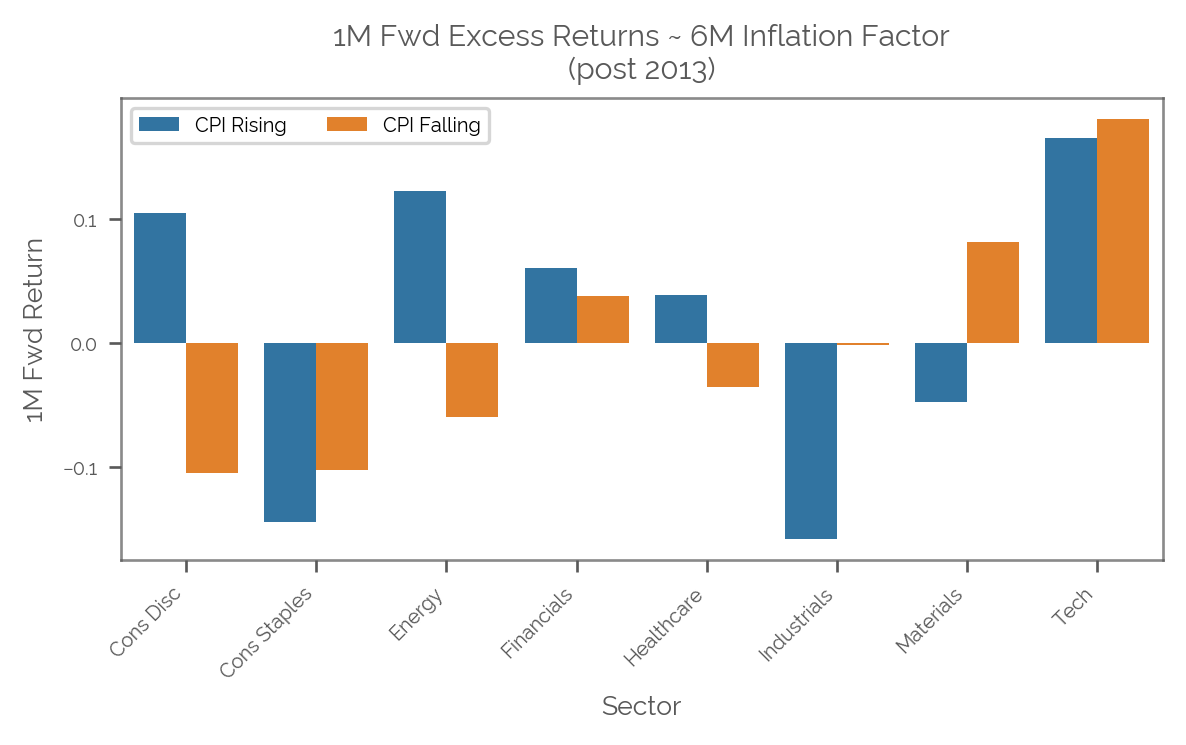

In [133]:
mask = df['date'] > pd.Timestamp(year=2013, month=1, day=1)

mean_returns = df[mask][df[factor_col].isna() == False].groupby(['ticker', factor_col], observed=True)[rtn_col].agg('mean')
excess_returns = mean_returns - mean_returns['spx']
excess_returns = excess_returns.reset_index()
excess_returns = excess_returns[excess_returns['ticker'] != 'spx']

returns = mean_returns
if use_excess_returns:
    returns = excess_returns
    if title is None:
        title = f"Excess Sector Returns {rtn_col} x {factor_col}"
else:
    returns = mean_returns.reset_index()
    if title is None:
        title = f"Sector Returns {rtn_col} x {factor_col}"

returns = pd.DataFrame(returns)
returns[rtn_col] = returns[rtn_col] * 100 #convert to pct scale
returns[factor_col] = pd.Categorical(returns[factor_col], 
                                     categories=[True, False], ordered=True)

returns.replace({'ticker': sector_map}, inplace=True)
returns.replace({factor_col: cpi_rising_map}, inplace=True)

plt.figure(figsize=figsize, dpi=dpi);
sb.barplot(returns, x='ticker', y=rtn_col, hue=factor_col, legend=True);
ax = plt.gca()
ax.legend(loc="upper left", ncol=2, fontsize=6);
plt.xticks(rotation=45, ha='right', fontsize=6);
plt.yticks(fontsize=6);
plt.ylabel("1M Fwd Return", fontsize=8);
plt.xlabel("Sector", fontsize=8);

plt.title("1M Fwd Excess Returns ~ 6M Inflation Factor\n(post 2013)", fontsize=9, color='#595959')

for spine in ax.spines.values():
    spine.set_color('#595959')
    spine.set_alpha(.7)
plt.show()

In [109]:
?sb.barplot

In [55]:
excess_returns.to_clipboard()

In [59]:
rising_tickers = returns[returns[factor_col] == True]['ticker'].values
rising_returns = returns[returns[factor_col] == True][rtn_col].values
falling_tickers = returns[returns[factor_col] == False]['ticker'].values
falling_returns = returns[returns[factor_col] == False][rtn_col].values

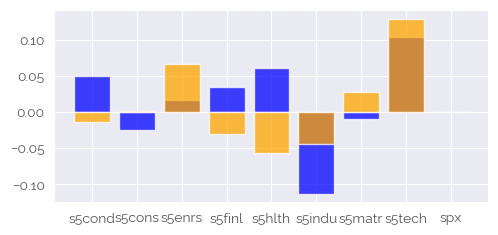

In [61]:
fig, ax = plt.subplots(figsize=figsize, dpi=dpi);
ax.bar(rising_tickers, rising_returns, color='blue', alpha=.75);

ax.bar(falling_tickers, falling_returns, color='orange', alpha=.75);
# plt.show()

In [63]:
returns[returns[factor_col] == True].to_clipboard()

In [64]:
returns[returns[factor_col] == False].to_clipboard()

In [ ]:

# ax.set_figure(figsize=(10,5))
plt.grid(ls='--', alpha=.5)
plt.xticks(rotation=45)
plt.title(title)

if xlabel is not None:
    plt.xlabel(xlabel)

if ylabel is not None:
    plt.ylabel(ylabel)


figname = f"img/excess_return_{factor_col}_{rtn_col}.png"
if use_excess_returns == False:
    figname = f"img/total_return_{factor_col}_{rtn_col}.png"
if save_plot:
    # print(f"Saving {figname}")
    plt.savefig(figname)

if show_plot:
    plt.show()

# fig, ax = plt.subplots(figsize=figsize, dpi=dpi)